In [76]:

import numpy as np
import pandas as pd
import os

import pickle
import torch
from aiirw import AI_IRW
import matplotlib.pyplot as plt
from _ood_classifier import OODDetector

import seaborn as sns

#import random search from sklearn
from sklearn.model_selection import RandomizedSearchCV
#import shuffle from sklearn
from sklearn.utils import shuffle
sns.set_style('white')
from sklearn.metrics import roc_auc_score, average_precision_score

In [55]:
with open('embeddings_imbd_train.pkl', 'rb') as f:
    embd_train = pickle.load(f)

with open('logits_imdb_train.pkl', 'rb') as f:
    logit_train = pickle.load(f)

with open('attns_imdb_train.pkl', 'rb') as f:
    attn_train = pickle.load(f)

In [56]:
embd_ood = []
logit_ood = []
attn_ood = []
ood_dict = {}

for fn in [el for el in os.listdir() if el.startswith('embeddings_ood_test_')]:

    _name = fn.split('_')[-1].split('.')[0]
    _vars = {}

    with open(fn, 'rb') as f:
        _embd = pickle.load(f)
    embd_ood += _embd

    _vars['embd'] = _embd

    with open(f"logits_ood_test_{_name}.pkl", 'rb') as f:
        _logit = pickle.load(f)
    logit_ood += _logit

    _vars['logit'] = _logit

    with open(f"attns_ood_test_{_name}.pkl", 'rb') as f:
        _attn = pickle.load(f)
    attn_ood += _attn

    _vars['attn'] = _attn   

    ood_dict[_name] = _vars 

In [57]:
with open('embeddings_imdb_test.pkl', 'rb') as f:
    embd_test = pickle.load(f)

with open('logits_imdb_test.pkl', 'rb') as f:
    logit_test = pickle.load(f)

with open('attns_imdb_test.pkl', 'rb') as f:
    attn_test = pickle.load(f)

In [58]:
logit_train = torch.cat(logit_train).numpy()
attn_train = torch.cat(attn_train).numpy()
embd_train = torch.cat(embd_train).numpy()

embd_train_distrib  = {l: embd_train[np.where(np.argmax(logit_train, axis=-1)==l)] for l in range(logit_train.shape[1])}
attn_train_distrib  = {l: attn_train[np.where(np.argmax(logit_train, axis=-1)==l)] for l in range(logit_train.shape[1])}
logit_train_distrib  = {l: logit_train[np.where(np.argmax(logit_train, axis=-1)==l)] for l in range(logit_train.shape[1])}

In [59]:
logit_test = torch.cat(logit_test).numpy()
embd_test = torch.cat(embd_test).numpy()
attn_test = torch.cat(attn_test).numpy()


embd_test_distrib  = {l: embd_test[np.where(np.argmax(logit_test, axis=-1)==l)] for l in range(logit_test.shape[1])}
attn_test_distrib  = {l: attn_test[np.where(np.argmax(logit_test, axis=-1)==l)] for l in range(logit_test.shape[1])}
logit_test_distrib  = {l: logit_test[np.where(np.argmax(logit_test, axis=-1)==l)] for l in range(logit_test.shape[1])}



In [60]:

# Aggregated
logit_ood = torch.cat(logit_ood).numpy()
embd_ood = torch.cat(embd_ood).numpy()
attn_ood = torch.cat(attn_ood).numpy()

embd_ood_distrib  = {l: embd_ood[np.where(np.argmax(logit_ood, axis=-1)==l)] for l in range(logit_ood.shape[1])}
attn_ood_distrib  = {l: attn_ood[np.where(np.argmax(logit_ood, axis=-1)==l)] for l in range(logit_ood.shape[1])}
logit_ood_distrib  = {l: logit_ood[np.where(np.argmax(logit_ood, axis=-1)==l)] for l in range(logit_ood.shape[1])}



#Per OOD-DS
for el in ood_dict.values():
    for _k, _v in el.items():
       el[_k] = torch.cat(_v).numpy()
        
    el['embd_ood_distrib']  = {l: el['embd'][np.where(np.argmax(el['logit'], axis=-1)==l)] for l in range(el['logit'].shape[1])}
    el['attn_ood_distrib']  = {l: el['attn'][np.where(np.argmax(el['logit'], axis=-1)==l)] for l in range(el['logit'].shape[1])}
    el['logit_ood_distrib']  = {l: el['logit'][np.where(np.argmax(el['logit'], axis=-1)==l)] for l in range(el['logit'].shape[1])}

    




In [9]:
X_0_embd =  np.concatenate((embd_ood_distrib[0], embd_test_distrib[0]))
X_0_attn =  np.concatenate((attn_ood_distrib[0], attn_test_distrib[0]))
y_0 =   np.concatenate((np.ones((embd_ood_distrib[0].shape[0])), np.zeros((embd_test_distrib[0].shape[0]))))

X_1_embd =  np.concatenate((embd_ood_distrib[1], embd_test_distrib[1]))
X_1_attn =  np.concatenate((attn_ood_distrib[1], attn_test_distrib[1]))
y_1 =   np.concatenate((np.ones((embd_ood_distrib[1].shape[0])), np.zeros((embd_test_distrib[1].shape[0]))))

X_embd = np.concatenate((logit_ood, logit_test))
X_attn = np.concatenate((attn_ood, attn_test))
y_ = np.concatenate((np.ones(logit_ood.shape[0]), np.zeros(logit_test.shape[0])))

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

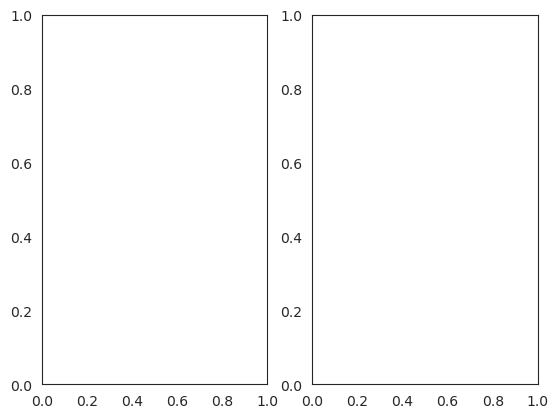

In [86]:
clfs = {i: OODDetector(similarity='IRW', base_distribution=embd_train_distrib[i], T=10).fit() for i in [0,1]
}
scores=[]
for ds_n,ood_ds in ood_dict.items():
    fig, axes = plt.subplots(1,2)
    for i in [0,1]:
        clf = clfs[i]
        y_true = np.concatenate((np.zeros(ood_ds['embd_ood_distrib'][i].shape[0]), np.ones(embd_test_distrib[i].shape[0])))
        X = np.concatenate((ood_ds['embd_ood_distrib'][i] ,embd_test_distrib[i]))
        #X, y_true = shuffle(X, y_true)
        
        y_score = clf.predict_proba(X)
        bins_width = (np.histogram(y_score[y_true==1])[1][3]-np.histogram(y_score[y_true==1])[1][2])/2 if i == 0 else bins_width
        sns.histplot(y_score[y_true==1][:,0], label='IN-DS', kde=True, stat='probability', color='skyblue', binwidth=bins_width, line_kws={"lw":3}, ax=axes[i])
        sns.histplot(y_score[y_true==0][:,0], label='OOD-DS', kde=True, stat='probability', color='red', binwidth=bins_width, line_kws={"lw":3}, ax=axes[i])
        auc_score = roc_auc_score(y_true=y_true, y_score=y_score)
        aupr = average_precision_score(y_true=y_true, y_score=y_score)
        scores.append([auc_score, aupr])
        axes[i].set_title("$\hat{y}=$" +f"{i} \n auroc : {scores[-1][0]:.2f}, aupr : {scores[-1][1]:.2f}")
        #plt.text(1,1,'$\hat{y}=0' if i ==0 else '$\hat{y}=1' )


    fig.suptitle(ds_n)
    plt.show()

print(np.mean(scores, axis=0))
    

In [78]:
np.histogram(y_score)

(array([19279,   148,    59,    53,    47,    32,    27,    27,    23,
           32]),
 array([3.2466650e-04, 5.0031226e-02, 9.9737786e-02, 1.4944434e-01,
        1.9915091e-01, 2.4885747e-01, 2.9856402e-01, 3.4827060e-01,
        3.9797714e-01, 4.4768372e-01, 4.9739027e-01], dtype=float32))

In [63]:
#import random search from sklearn
from sklearn.model_selection import RandomizedSearchCV
#import shuffle from sklearn
from sklearn.utils import shuffle

X_0, y_0 = shuffle(X_0, y_0)
X_1, y_1 = shuffle(X_1, y_1)
X_, y_ = shuffle(X_, y_)

# Create the parameter grid based on the results of random search, tau follows a gaussian centered in 50 with std 10
param_grid = {
    'tau': np.random.uniform(-150, 0, 100), 
    'similarity': ['mahalanobis'],
    'base_distribution' : [train_distrib[0]]
}

# Create a based model
clf = OODDetector(similarity='mahalanobis', tau=50, base_distribution=train_distrib[0])

# Instantiate the grid search model
grid_search = RandomizedSearchCV(estimator = clf, param_distributions = param_grid,
                            cv = 5, n_jobs = -1, verbose = 0, scoring='balanced_accuracy')


NameError: name 'X_0' is not defined

In [41]:
grid_search.fit(X_0, y_0)
print(grid_search.best_params_)

{'tau': -53.24070283187717, 'similarity': 'mahalanobis', 'base_distribution': array([[ 0.1655158 ,  0.19259338, -0.05701194, ..., -0.04087529,
         0.06450007,  0.27201617],
       [ 0.26176506,  0.13326405,  0.04254614, ..., -0.02392149,
         0.06750306,  0.20914446],
       [ 0.16050506, -0.07738341,  0.21776502, ..., -0.1432903 ,
        -0.04918719, -0.1345499 ],
       ...,
       [-0.07087212, -0.27570873,  0.08874413, ..., -0.14185995,
        -0.05530067, -0.18070912],
       [-0.13870718, -0.08804137, -0.18017988, ..., -0.1654126 ,
        -0.06333739, -0.11101169],
       [ 0.00867541, -0.23554574,  0.14202845, ..., -0.29557773,
        -0.16673136, -0.346024  ]], dtype=float32)}


In [17]:
grid_search.best_score_

0.9770796974985456

In [18]:
 clf = OODDetector(similarity='wass2unif', tau=1).fit()

In [27]:
roc_auc_score(y_, clf.predict_proba(X_attn))

0.7275677363079762

In [24]:
clf.predict_proba(X_attn)

array([-0.46052711, -0.46052711, -0.46052711, ..., -0.61499868,
       -0.73865306, -0.77258298])

(array([1057., 1144.,  776.,  610.,  391.,  282., 1319.,  240.,  282.,
         123.]),
 array([-0.77950614, -0.73265803, -0.68580992, -0.63896181, -0.5921137 ,
        -0.54526559, -0.49841748, -0.45156937, -0.40472126, -0.35787316,
        -0.31102505]),
 <BarContainer object of 10 artists>)

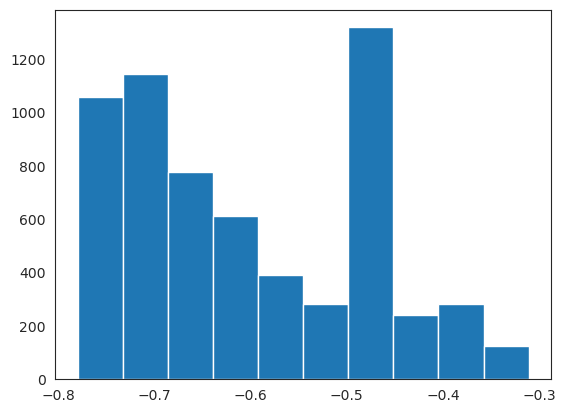

In [21]:
plt.hist(clf._compute_sim(attn_ood_distrib[1]))

(array([5545.,  942.,  491.,  245.,  182.,  117.,   98.,   76.,   90.,
          24.]),
 array([-0.74782239, -0.70987861, -0.67193484, -0.63399106, -0.59604729,
        -0.55810351, -0.52015974, -0.48221596, -0.44427218, -0.40632841,
        -0.36838463]),
 <BarContainer object of 10 artists>)

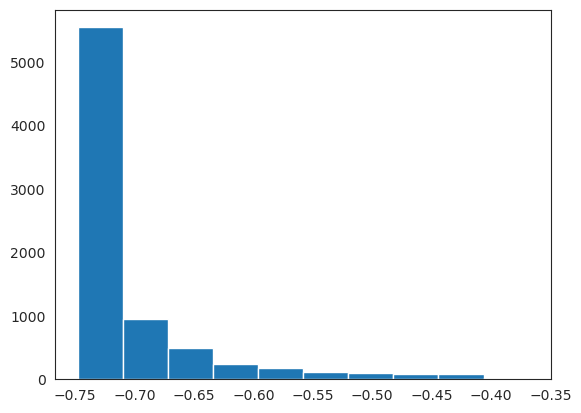

In [22]:
plt.hist(clf._compute_sim(attn_test_distrib[1]))

In [17]:
clf.(X_0_attn)

array([1, 1, 1, ..., 1, 1, 1])

In [38]:
clf = OODDetector(tau=1, similarity='wass2unif',k=100,  base_distribution=attn_train_distrib[1][:1000]).fit()

[]

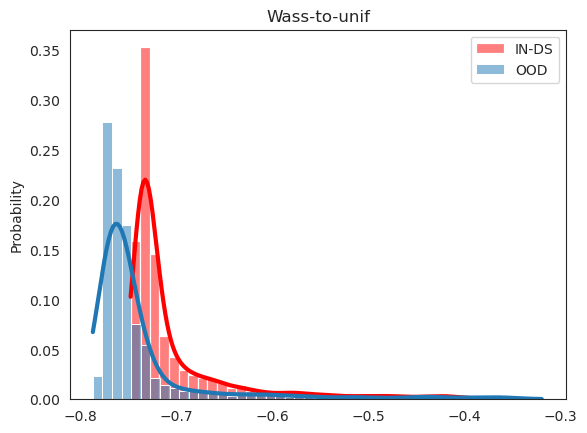

In [42]:
direction = 1
bins_width = .01
sns.histplot(clf._compute_sim(attn_test_distrib[direction]), label='IN-DS', kde=True, stat='probability', color='red', binwidth=bins_width, line_kws={"lw":3})
sns.histplot(clf._compute_sim(attn_ood_distrib[direction]), label="OOD", kde=True, stat='probability', binwidth=bins_width, line_kws={"lw":3})
plt.legend()
plt.title("Wass-to-unif")
plt.plot()

In [28]:
from _ood_classifier import partial_wrapper
from scipy.spatial.distance import cdist

In [ ]:
np.mean(np.sort( partial_wrapper( cdist, XB=self.base_distribution, metric="cityblock")(x),axis=-1)[:, : self.k]    )

In [29]:
a = cdist(attn_test_distrib[0], attn_train_distrib[0][:100], metric='cityblock')

In [36]:
np.mean(np.sort(a, axis=-1)[:, :2], axis=-1).shape

(17190,)